# 📊 접근 로그 분석 노트북

**분석 대상**: `koroad_kiosk` (한국도로공사 키오스크 접근 로그)

---

## 1. 환경 설정

In [1]:
# ===== Autoreload 설정 =====
%load_ext autoreload
%autoreload 2

# ===== 기본 라이브러리 =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===== DB 유틸리티 =====
from db_utils import get_dataframe, list_databases, get_tables, preview, save_dataframe

# ===== 시각화 설정 (Robust Font Fix) =====
import matplotlib.font_manager as fm
import matplotlib as mpl

font_path = '/usr/share/fonts/noto/NotoSansCJKkr-Regular.otf'
if os.path.exists(font_path):
    # 폰트 등록 (Matplotlib 3.2+ 호환 방식)
    fm.fontManager.addfont(font_path)
    prop = fm.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Font successfully set to: {prop.get_name()}")
else:
    print("Warning: Font file not found. Falling back to default.")

plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style='whitegrid', font=plt.rcParams['font.family'])

# ===== pandas 출력 설정 =====
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

In [2]:
# ========================================
# 🔧 이 셀만 수정하면 다른 DB로 전환 가능
# ========================================
DB_ALIAS = "koroad_kiosk"  # db_config.json에 정의된 DB 별칭

# 사용 가능한 DB 목록 확인
list_databases()

사용 가능한 데이터베이스 목록

📦 koroad_portal
   유형: postgresql
   DB명: da
   설명: 한국도로공사 내부 포털 접근 로그 DB

📦 koroad_kiosk
   유형: mariadb
   DB명: koroad
   설명: 한국도로공사 키오스크 접근 로그 DB

📦 suwon_platform
   유형: postgresql
   DB명: suwon
   설명: 수원시 내부 포털 접근 로그 DB

📦 suwon_portal
   유형: postgresql
   DB명: postgres
   설명: 수원시 외부 포털 접근 로그 DB



## 2. 데이터 로드

In [3]:
# 테이블 목록 확인
tables = get_tables(DB_ALIAS)
tables

/DATA/jupyter_WorkingDirectory/notebook/Access_Analysis/db_utils.py:243: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,table_name,table_type
0,ka_call_seq,BASE TABLE
1,ka_summary_hourly,BASE TABLE
2,ka_ticket_stats,BASE TABLE
3,lcexct_branch_predt_avg_tbl,BASE TABLE
4,lcexct_dgfcf_predt_tbl,BASE TABLE
5,tm_ka_branch,BASE TABLE
6,tm_ka_branch_location,BASE TABLE
7,tm_ka_call,BASE TABLE
8,tm_ka_desk,BASE TABLE
9,tm_ka_task,BASE TABLE


In [ ]:
# ===== 데이터 로드 (쿼리 수정) =====
query = """
SELECT *
FROM ka_ticket_stats
"""

df = get_dataframe(DB_ALIAS, query)
print(f"로드된 데이터: {df.shape[0]:,}행 x {df.shape[1]}열")
df.head()

/DATA/jupyter_WorkingDirectory/notebook/Access_Analysis/db_utils.py:243: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [ ]:
df['task_ymd'] = pd.to_datetime(df['task_ymd'])

In [ ]:
df[(df['branch_nm'] == '서부운전면허시험장')&(df['task_nm']=='면허발급')].groupby(['task_ymd'])

## 3. 서울 지역 주요 시험장 분석 (강남, 서부, 도봉, 강서)
2024년과 2025년의 11~12월 데이터를 비교하여 연말 혼잡도와 2025년 11월 10일 시행된 **혼잡도 분산 정책**의 효과를 분석합니다.

In [ ]:
# 서울 지역 시험장 목록
seoul_branches = ['강남운전면허시험장', '도봉운전면허시험장', '강서운전면허시험장', '서부운전면허시험장']

# 시간 데이터(timedelta 형식)를 초 단위 수치로 변환
def to_seconds(td):
    if pd.isna(td): return np.nan
    if isinstance(td, str):
        try: return pd.to_timedelta(td).total_seconds()
        except: return np.nan
    return td.total_seconds()

# '면허발급' 업무 위주로 필터링 (가장 대기가 긴 업무군)
df['delay_sec'] = df['delay_time'].apply(to_seconds)
seoul_df = df[df['branch_nm'].isin(seoul_branches) & (df['task_nm'] == '면허발급')].copy()
seoul_df['task_ymd'] = pd.to_datetime(seoul_df['task_ymd'])
seoul_df['year'] = seoul_df['task_ymd'].dt.year
seoul_df['month'] = seoul_df['task_ymd'].dt.month
seoul_df = seoul_df[seoul_df['month'].isin([11, 12])].copy()

print(f"서울 지역 면허발급 데이터 필터링 완료: {len(seoul_df):,}건")

서울 지역 면허발급 데이터 필터링 완료: 2,634,413건


In [ ]:
# 일별/시험장별 집계 (최대 대기인원 및 평균 대기시간)
daily_stats = seoul_df.groupby(['branch_nm', 'task_ymd']).agg({
    'standby_cnt': 'max',
    'delay_sec': 'mean'
}).reset_index()

daily_stats['delay_min'] = daily_stats['delay_sec'] / 60
daily_stats['year'] = daily_stats['task_ymd'].dt.year
daily_stats['month'] = daily_stats['task_ymd'].dt.month

daily_stats.head()

,branch_nm,task_ymd,standby_cnt,delay_sec,delay_min,year,month
0,강남운전면허시험장,2024-01-02,392,4676.581210,77.943020,2024,1
1,강남운전면허시험장,2024-01-03,77,1263.247111,21.054119,2024,1
2,강남운전면허시험장,2024-01-04,66,1297.054902,21.617582,2024,1
3,강남운전면허시험장,2024-01-05,158,2490.001894,41.500032,2024,1
4,강남운전면허시험장,2024-01-08,58,613.062340,10.217706,2024,1


/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) De

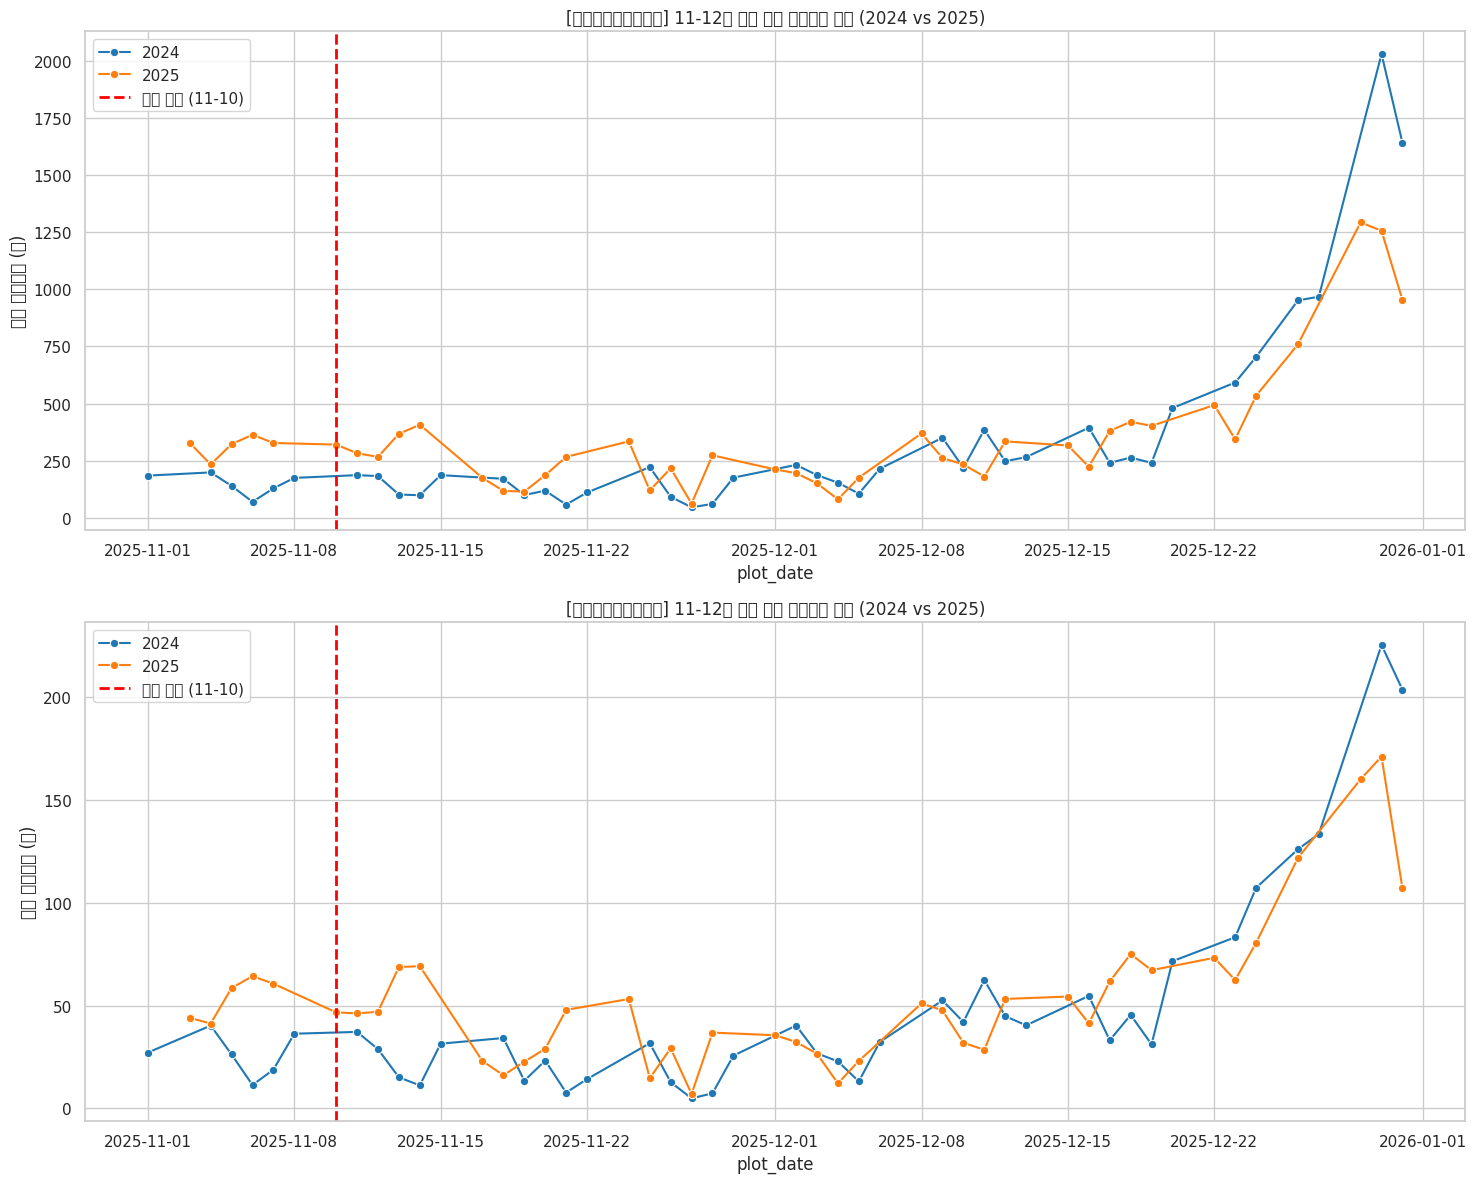

/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Deja

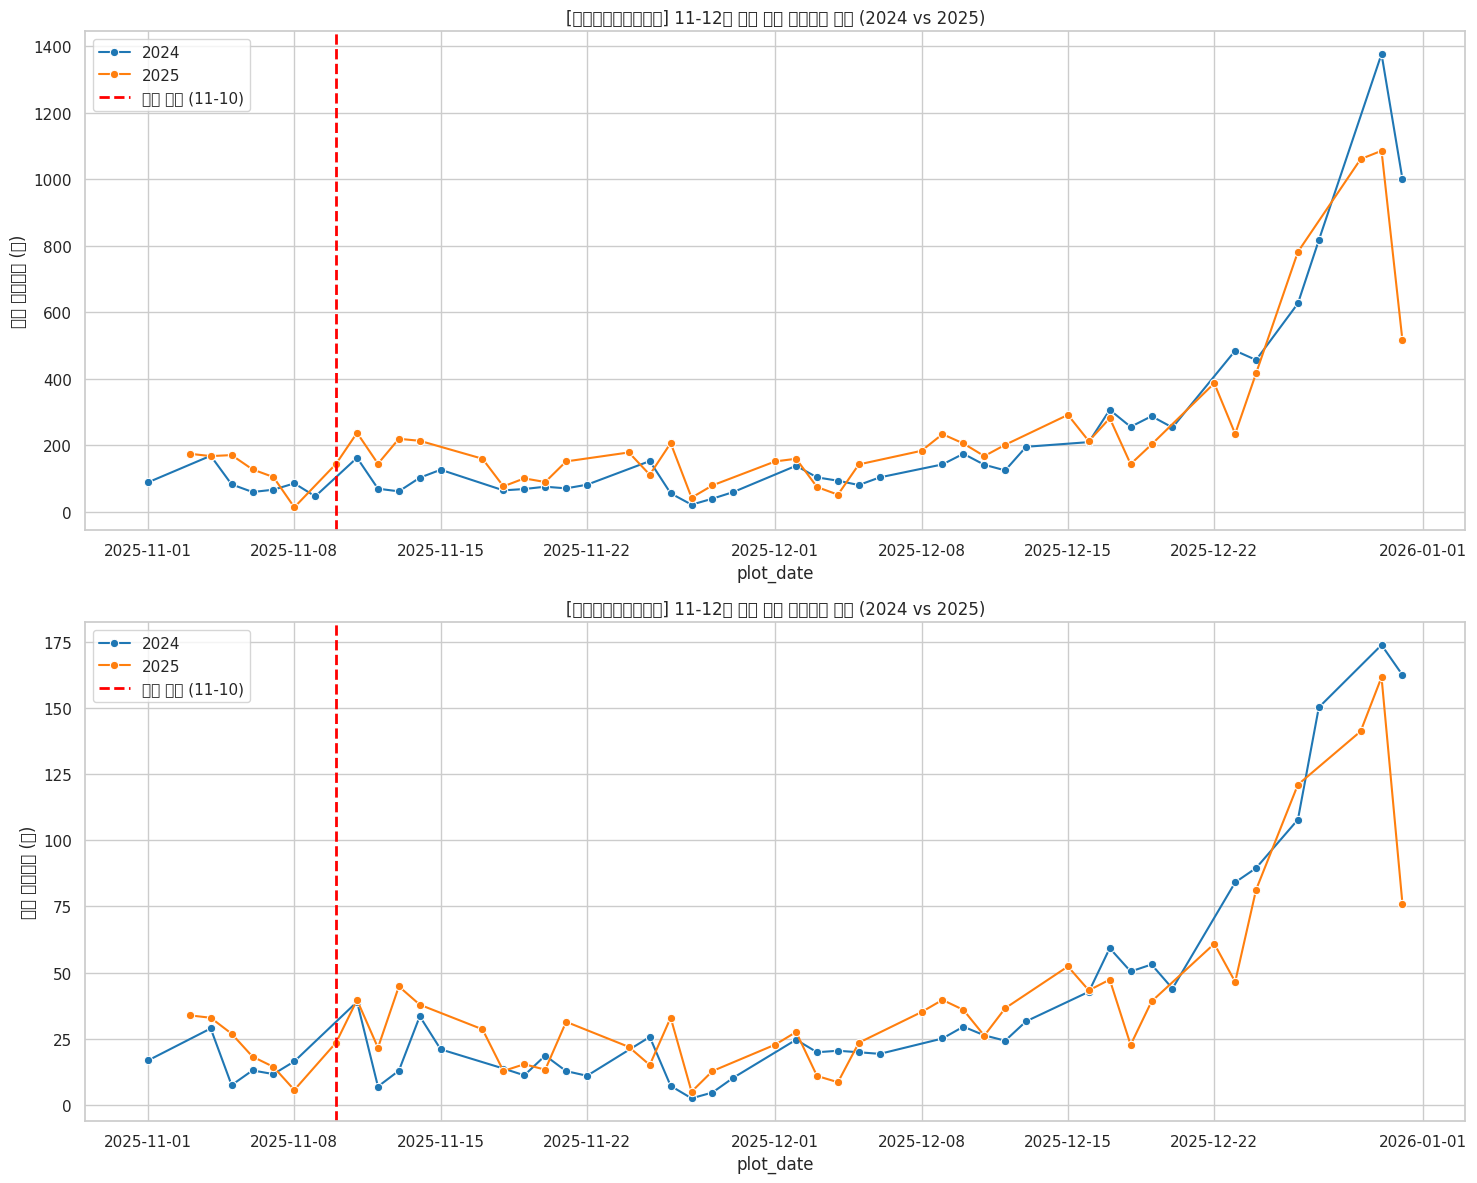

/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) De

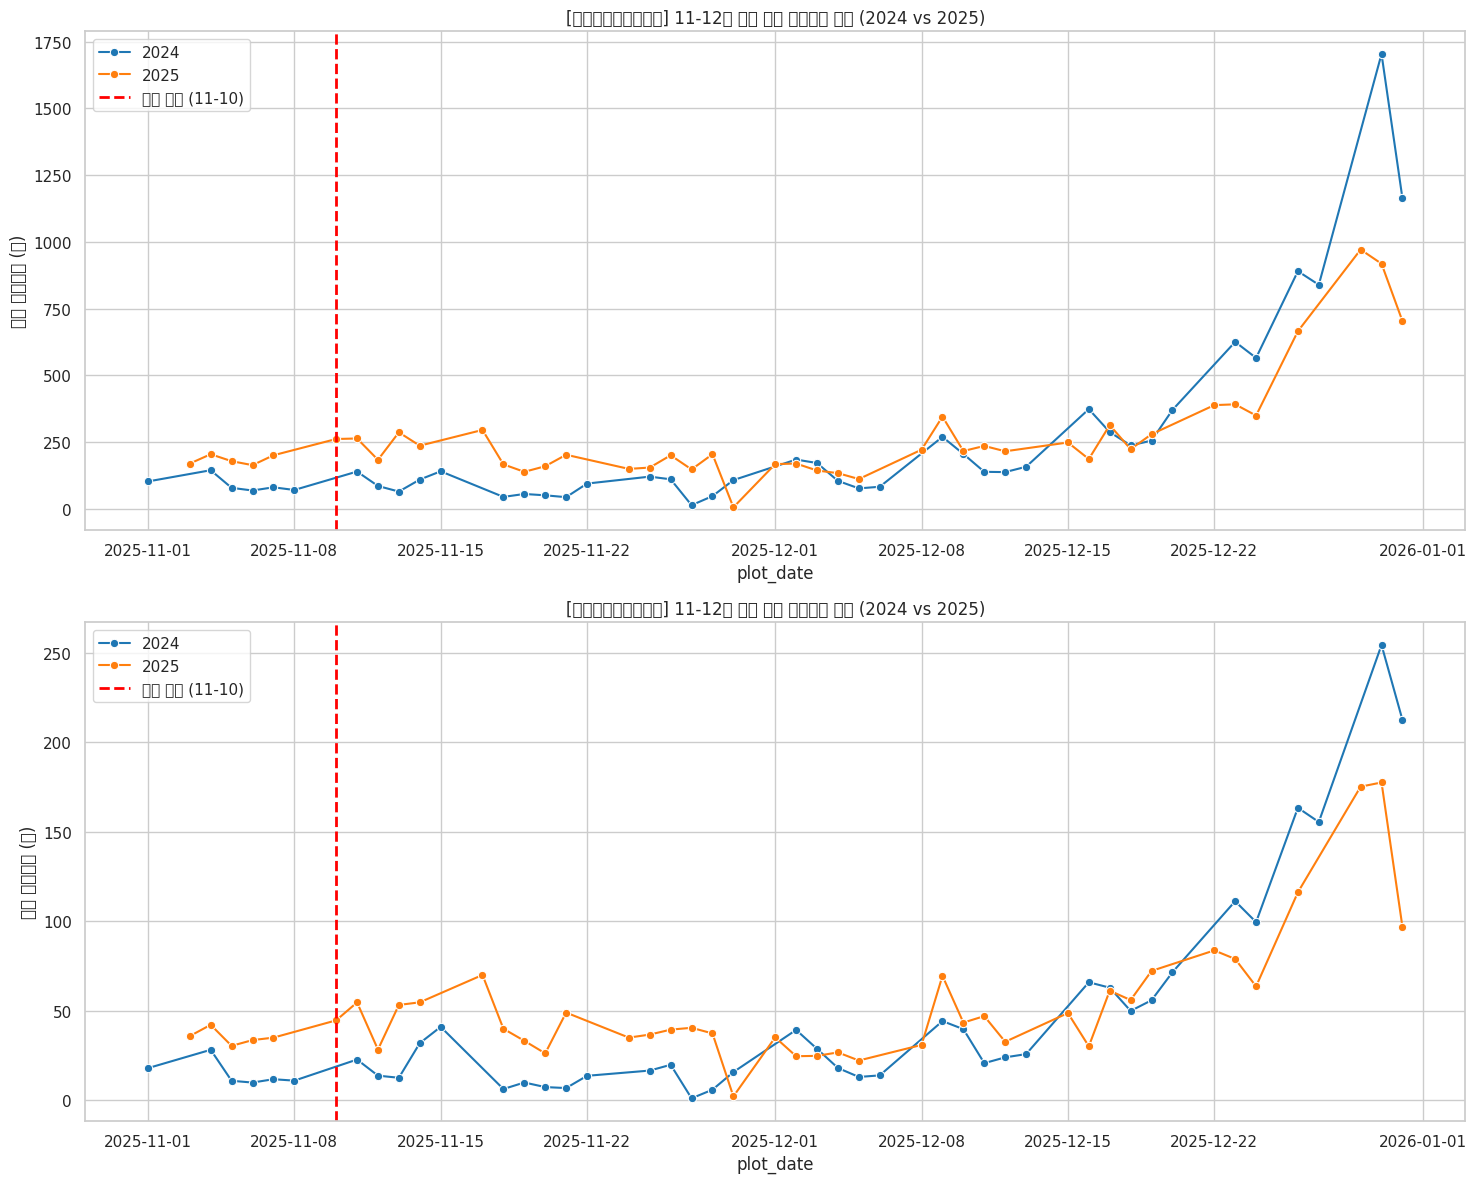

/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) Dej

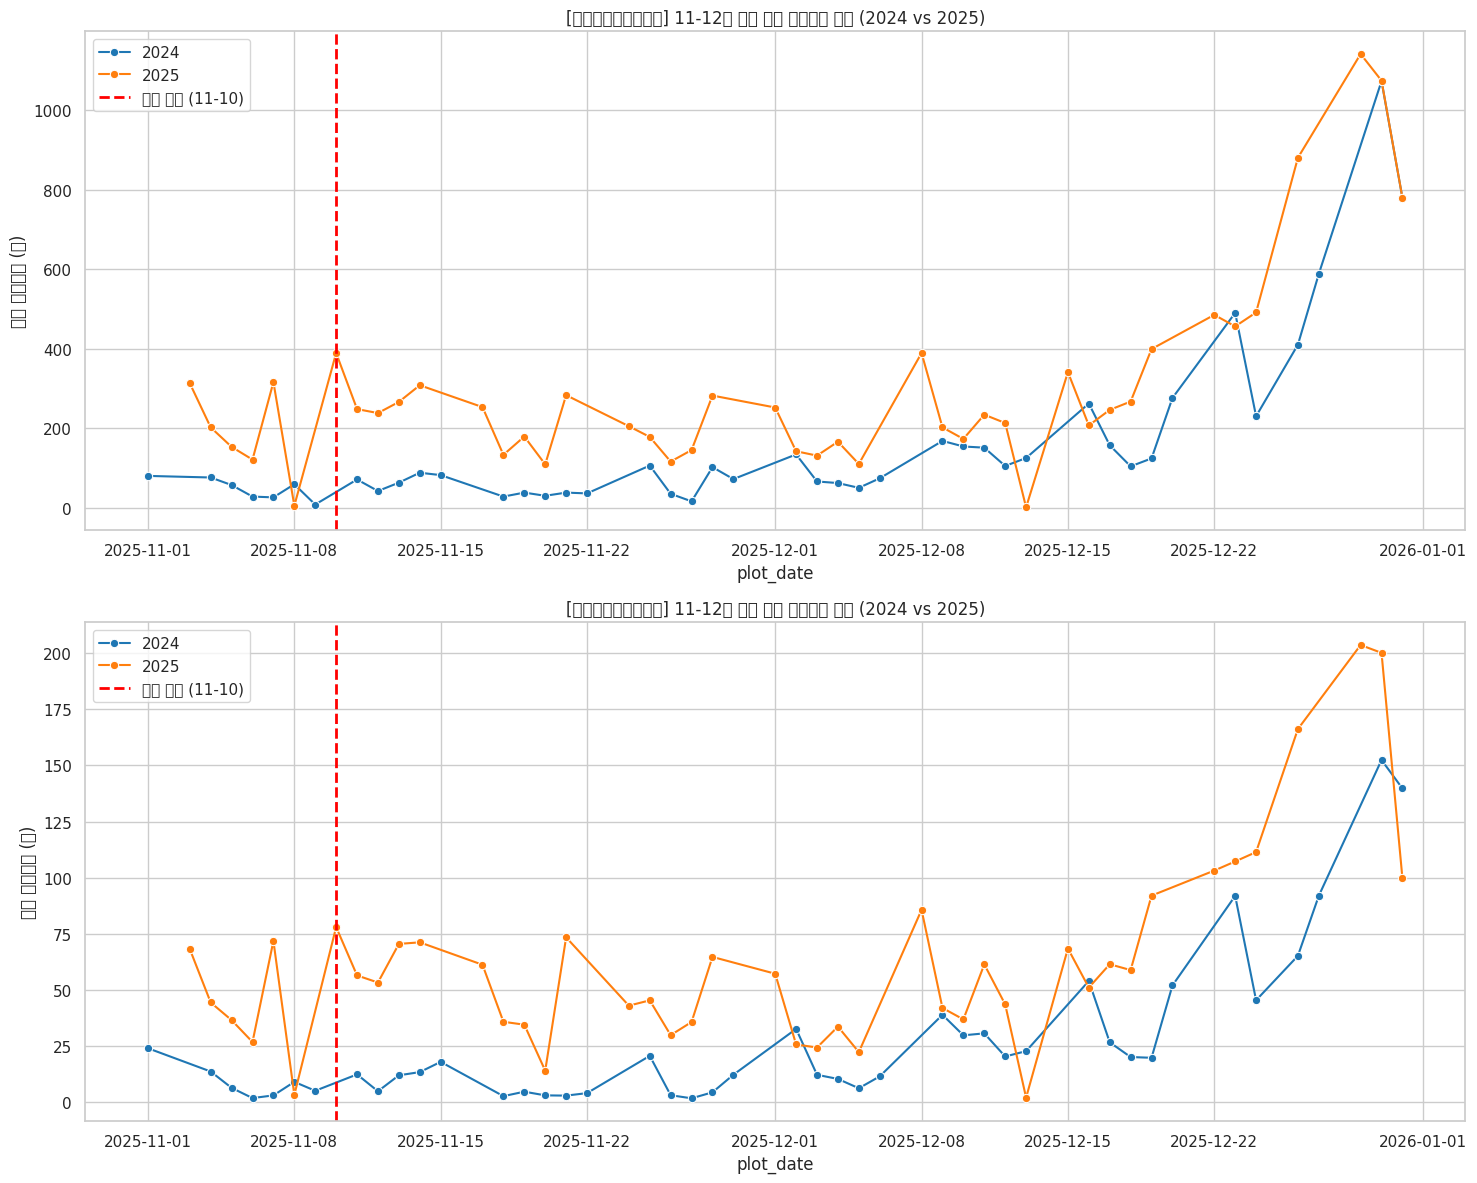

In [ ]:
# 2024 vs 2025 11~12월 추이 비교 시각화
def plot_trend_comparison(branch_name):
    target_months = [11, 12]
    data = daily_stats[(daily_stats['branch_nm'] == branch_name) & 
                       (daily_stats['month'].isin(target_months))].copy()
    
    # 연도별 비교를 위해 날짜를 동일한 연도(2025)로 가상 변환하여 오버레이
    data['plot_date'] = data['task_ymd'].apply(lambda d: d.replace(year=2025))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # 1. 최대 대기인원
    sns.lineplot(data=data, x='plot_date', y='standby_cnt', hue='year', palette='tab10', marker='o', ax=ax1)
    ax1.set_title(f"[{branch_name}] 11-12월 일별 최대 대기인원 비교 (2024 vs 2025)")
    ax1.set_ylabel("최대 대기인원 (명)")
    
    # 2. 평균 대기시간
    sns.lineplot(data=data, x='plot_date', y='delay_min', hue='year', palette='tab10', marker='o', ax=ax2)
    ax2.set_title(f"[{branch_name}] 11-12월 일별 평균 대기시간 비교 (2024 vs 2025)")
    ax2.set_ylabel("평균 대기시간 (분)")
    
    # 정책 실시일 표시 (2025-11-10)
    policy_date = pd.Timestamp('2025-11-10')
    for ax in [ax1, ax2]:
        ax.axvline(x=policy_date, color='red', linestyle='--', linewidth=2, label='정책 실시 (11-10)')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# 각 시험장별 시각화 실행
for branch in seoul_branches:
    plot_trend_comparison(branch)

## 3. 서울 지역 주요 시험장 분석 (강남, 서부, 도봉, 강서)
2024년과 2025년의 11~12월 데이터를 비교하여 연말 혼잡도와 2025년 11월 10일 시행된 **혼잡도 분산 정책**의 효과를 분석합니다.

In [ ]:
# 서울 지역 시험장 목록
seoul_branches = ['강남운전면허시험장', '도봉운전면허시험장', '강서운전면허시험장', '서부운전면허시험장']

# 시간 데이터(timedelta 형식)를 초 단위 수치로 변환
def to_seconds(td):
    if pd.isna(td): return np.nan
    if isinstance(td, str):
        try: return pd.to_timedelta(td).total_seconds()
        except: return np.nan
    return td.total_seconds()

# '면허발급' 업무 위주로 필터링 (가장 대기가 긴 업무군)
df['delay_sec'] = df['delay_time'].apply(to_seconds)
seoul_df = df[df['branch_nm'].isin(seoul_branches) & (df['task_nm'] == '면허발급')].copy()
seoul_df['task_ymd'] = pd.to_datetime(seoul_df['task_ymd'])
seoul_df['year'] = seoul_df['task_ymd'].dt.year
seoul_df['month'] = seoul_df['task_ymd'].dt.month
seoul_df = seoul_df[seoul_df['month'].isin([11, 12])].copy()

print(f"서울 지역 면허발급 데이터 필터링 완료: {len(seoul_df):,}건")

서울 지역 면허발급 데이터 필터링 완료: 2,634,413건


In [ ]:
# 일별/시험장별 집계 (최대 대기인원 및 평균 대기시간)
daily_stats = seoul_df.groupby(['branch_nm', 'task_ymd']).agg({
    'standby_cnt': 'max',
    'delay_sec': 'mean'
}).reset_index()

daily_stats['delay_min'] = daily_stats['delay_sec'] / 60
daily_stats['year'] = daily_stats['task_ymd'].dt.year
daily_stats['month'] = daily_stats['task_ymd'].dt.month

daily_stats.head()

,branch_nm,task_ymd,standby_cnt,delay_sec,delay_min,year,month
0,강남운전면허시험장,2024-01-02,392,4676.581210,77.943020,2024,1
1,강남운전면허시험장,2024-01-03,77,1263.247111,21.054119,2024,1
2,강남운전면허시험장,2024-01-04,66,1297.054902,21.617582,2024,1
3,강남운전면허시험장,2024-01-05,158,2490.001894,41.500032,2024,1
4,강남운전면허시험장,2024-01-08,58,613.062340,10.217706,2024,1


/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) De

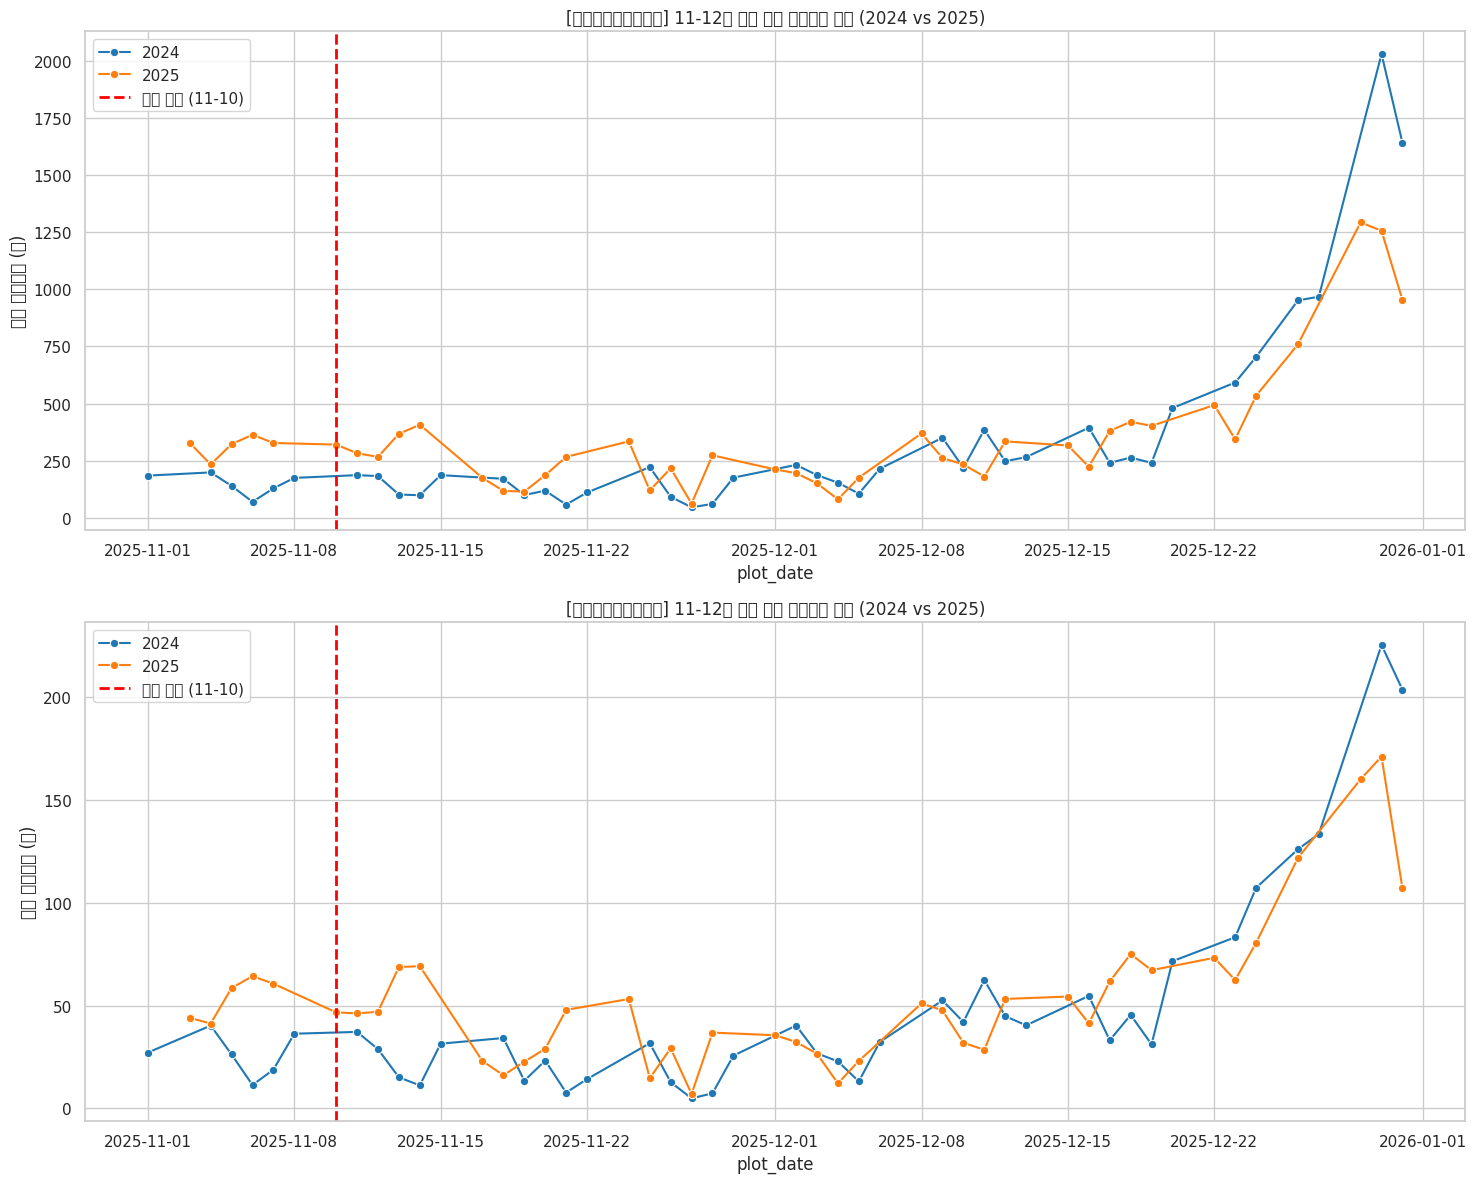

/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) Deja

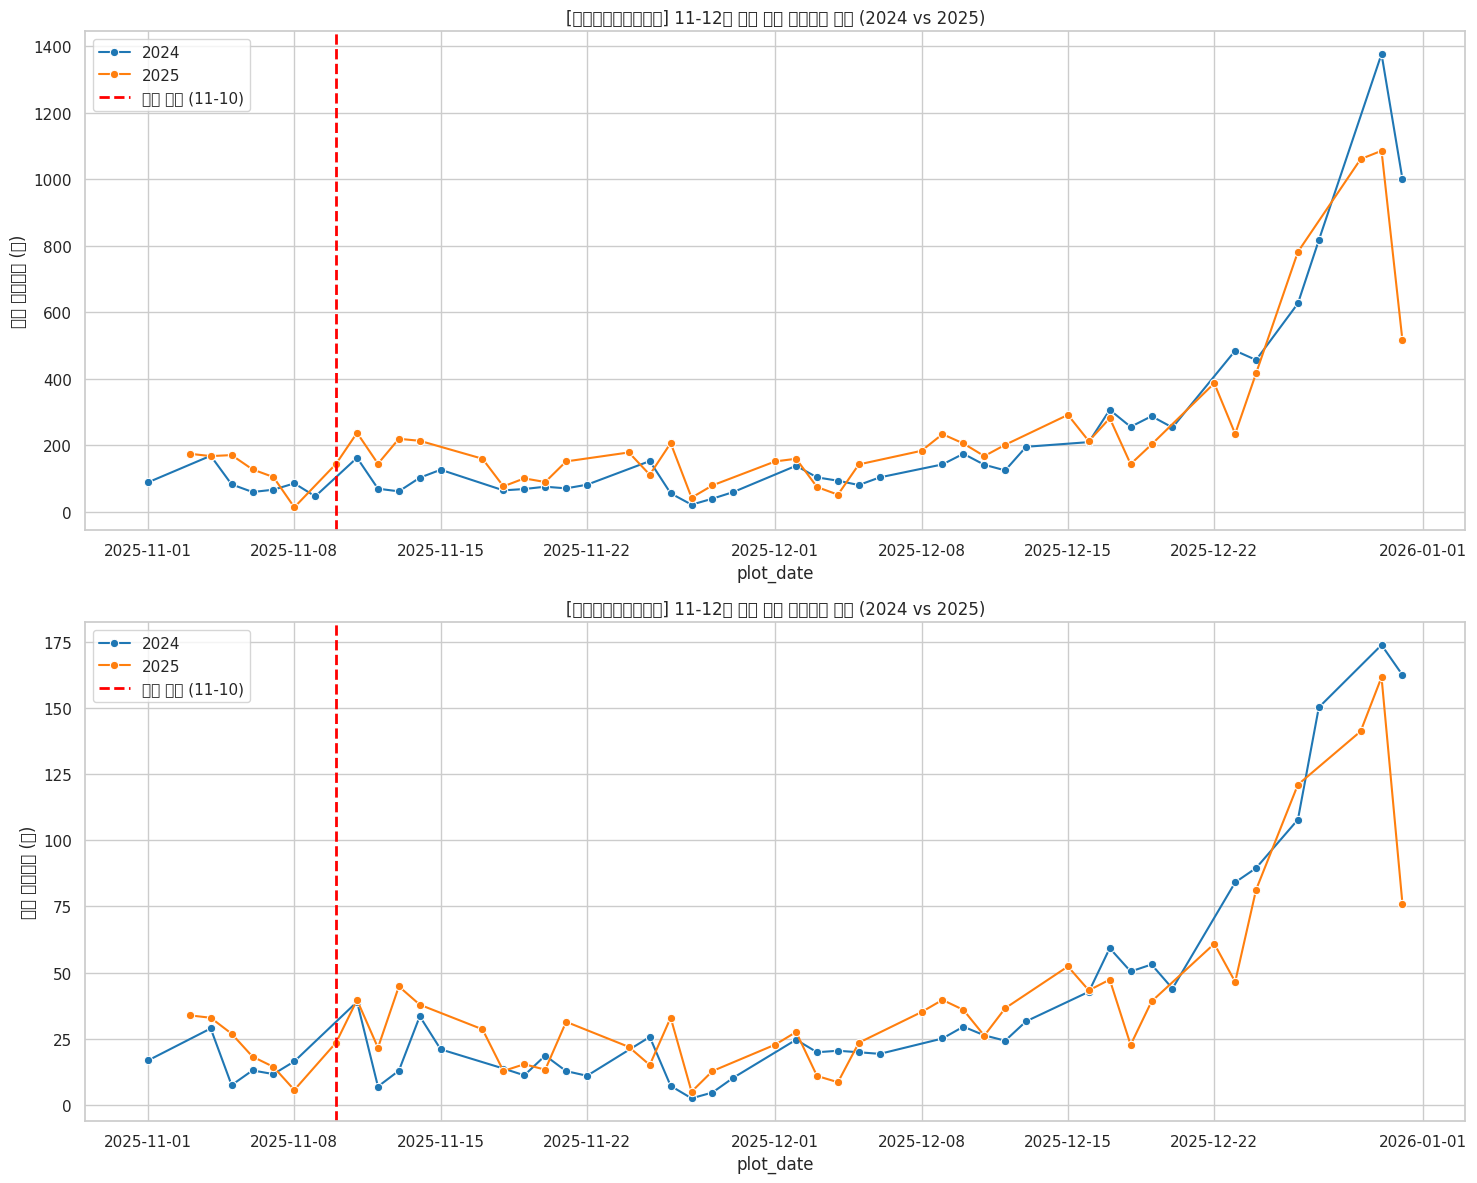

/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) De

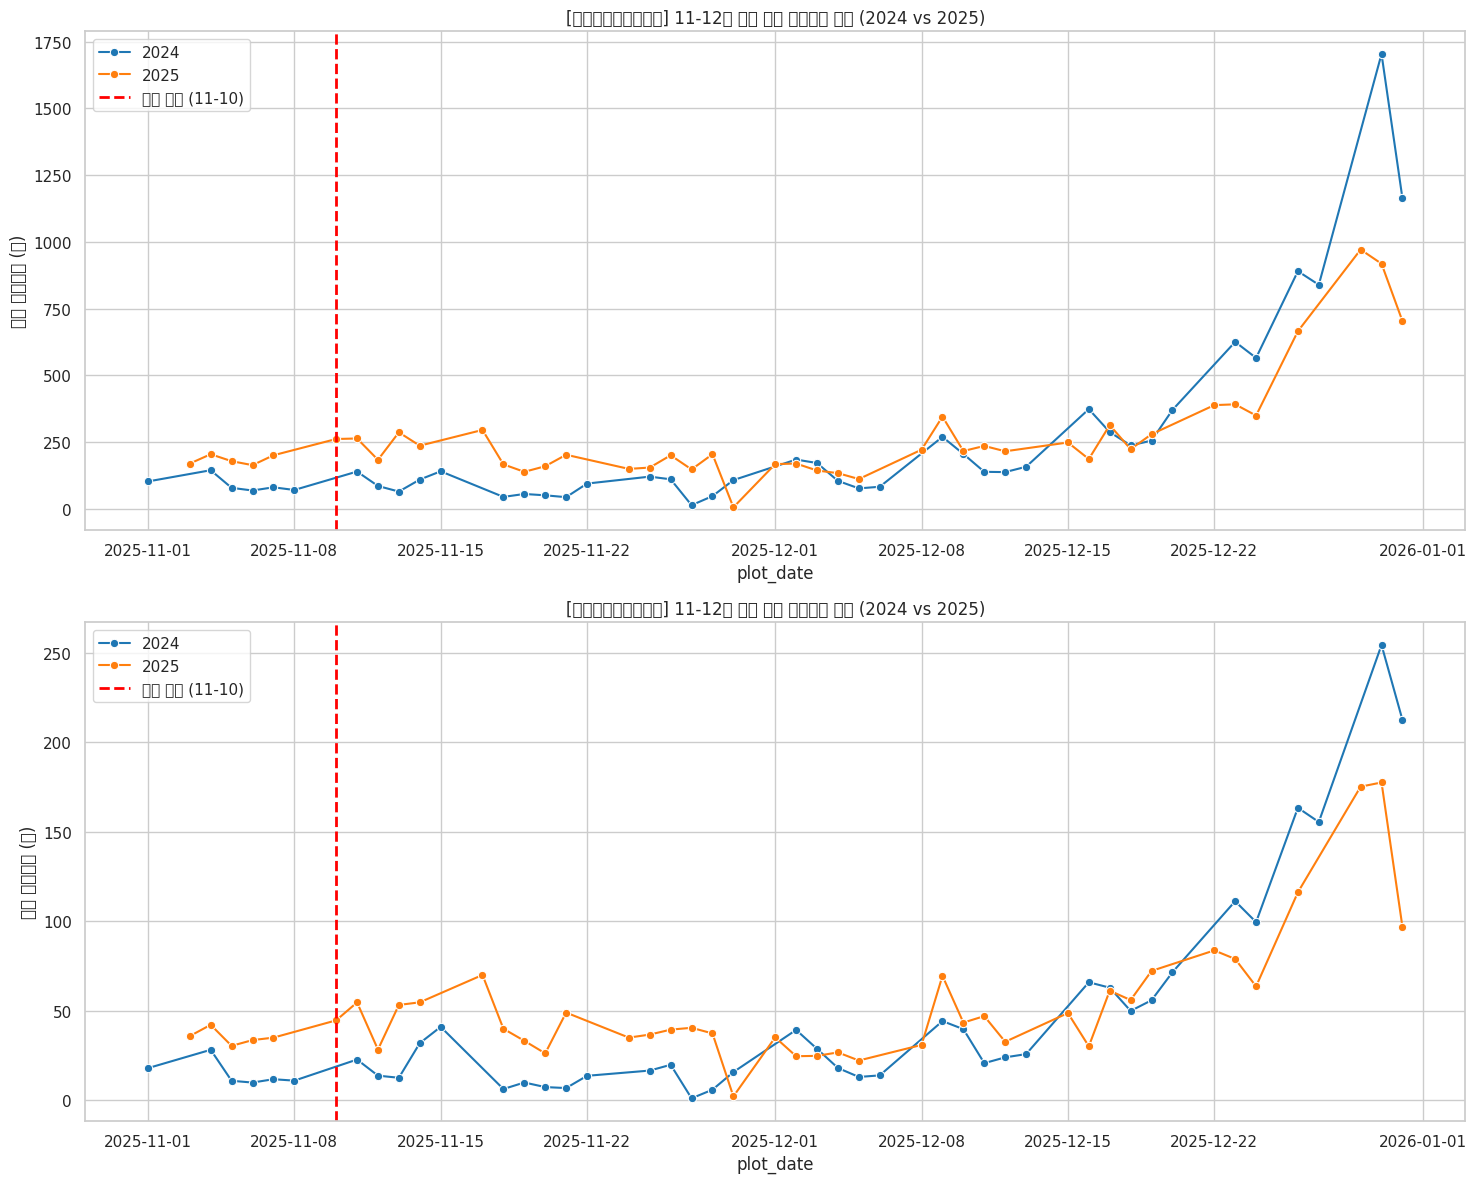

/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1388008/1206220718.py:28: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) Dej

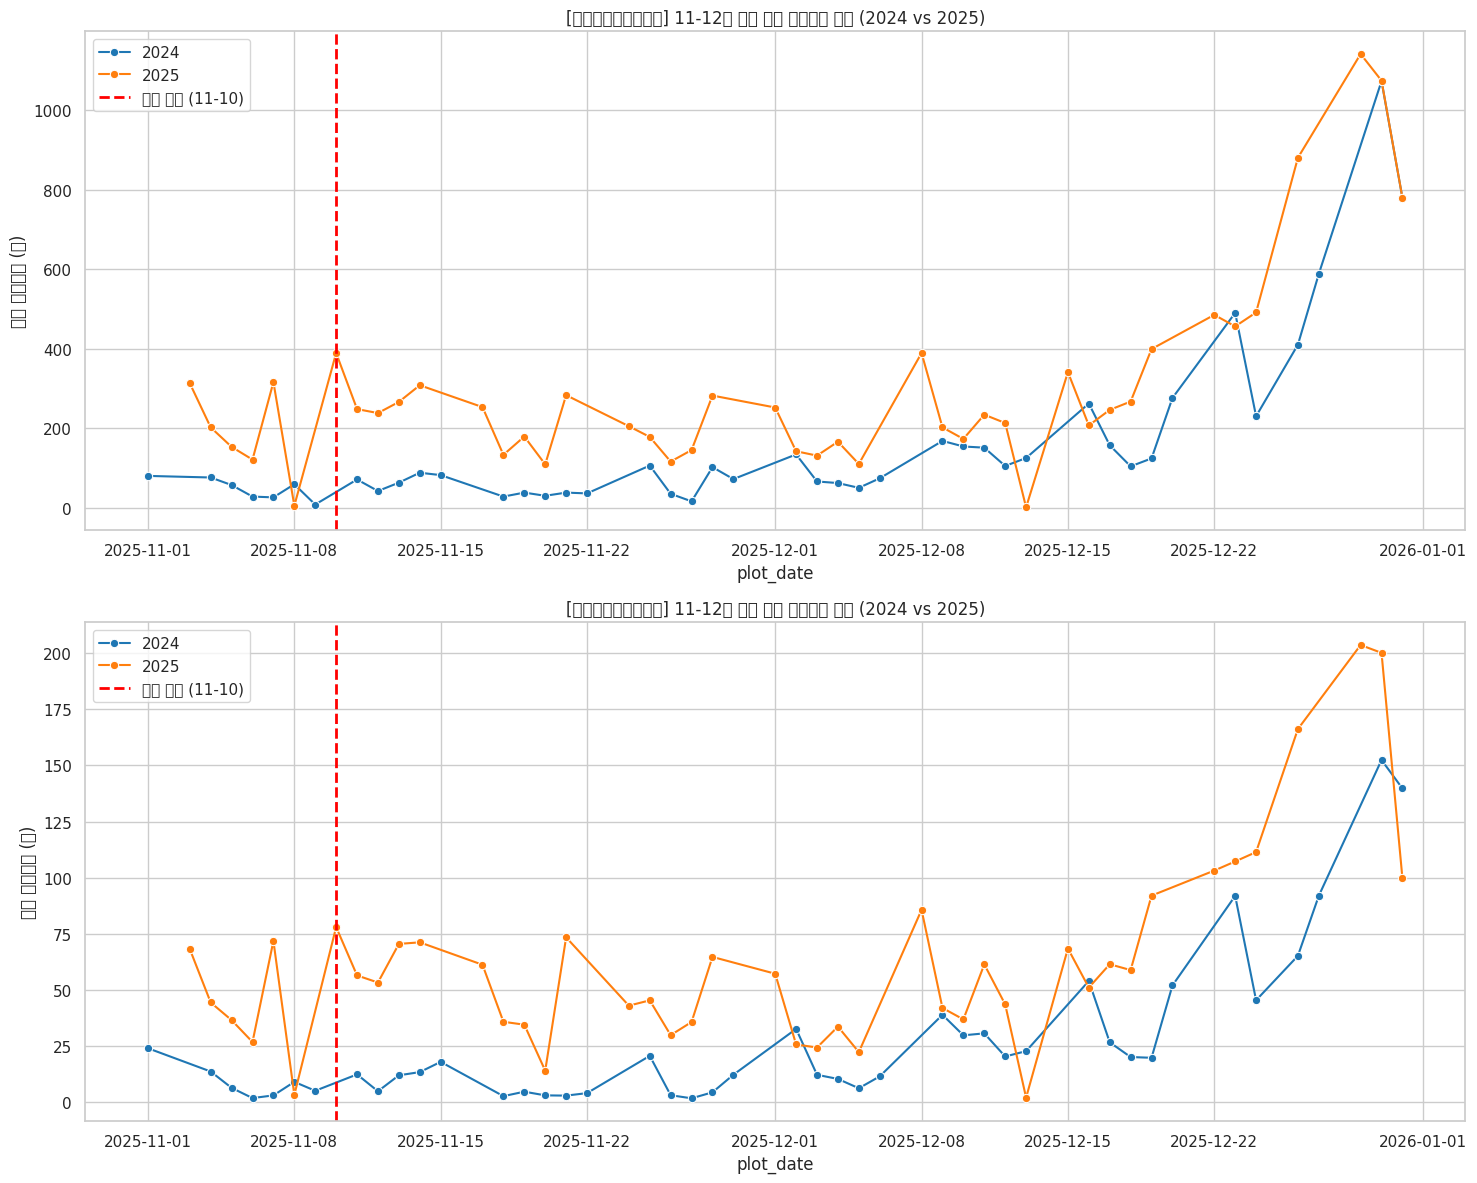

In [ ]:
# 2024 vs 2025 11~12월 추이 비교 시각화
def plot_trend_comparison(branch_name):
    target_months = [11, 12]
    data = daily_stats[(daily_stats['branch_nm'] == branch_name) & 
                       (daily_stats['month'].isin(target_months))].copy()
    
    # 연도별 비교를 위해 날짜를 동일한 연도(2025)로 가상 변환하여 오버레이
    data['plot_date'] = data['task_ymd'].apply(lambda d: d.replace(year=2025))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # 1. 최대 대기인원
    sns.lineplot(data=data, x='plot_date', y='standby_cnt', hue='year', palette='tab10', marker='o', ax=ax1)
    ax1.set_title(f"[{branch_name}] 11-12월 일별 최대 대기인원 비교 (2024 vs 2025)")
    ax1.set_ylabel("최대 대기인원 (명)")
    
    # 2. 평균 대기시간
    sns.lineplot(data=data, x='plot_date', y='delay_min', hue='year', palette='tab10', marker='o', ax=ax2)
    ax2.set_title(f"[{branch_name}] 11-12월 일별 평균 대기시간 비교 (2024 vs 2025)")
    ax2.set_ylabel("평균 대기시간 (분)")
    
    # 정책 실시일 표시 (2025-11-10)
    policy_date = pd.Timestamp('2025-11-10')
    for ax in [ax1, ax2]:
        ax.axvline(x=policy_date, color='red', linestyle='--', linewidth=2, label='정책 실시 (11-10)')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# 각 시험장별 시각화 실행
for branch in seoul_branches:
    plot_trend_comparison(branch)